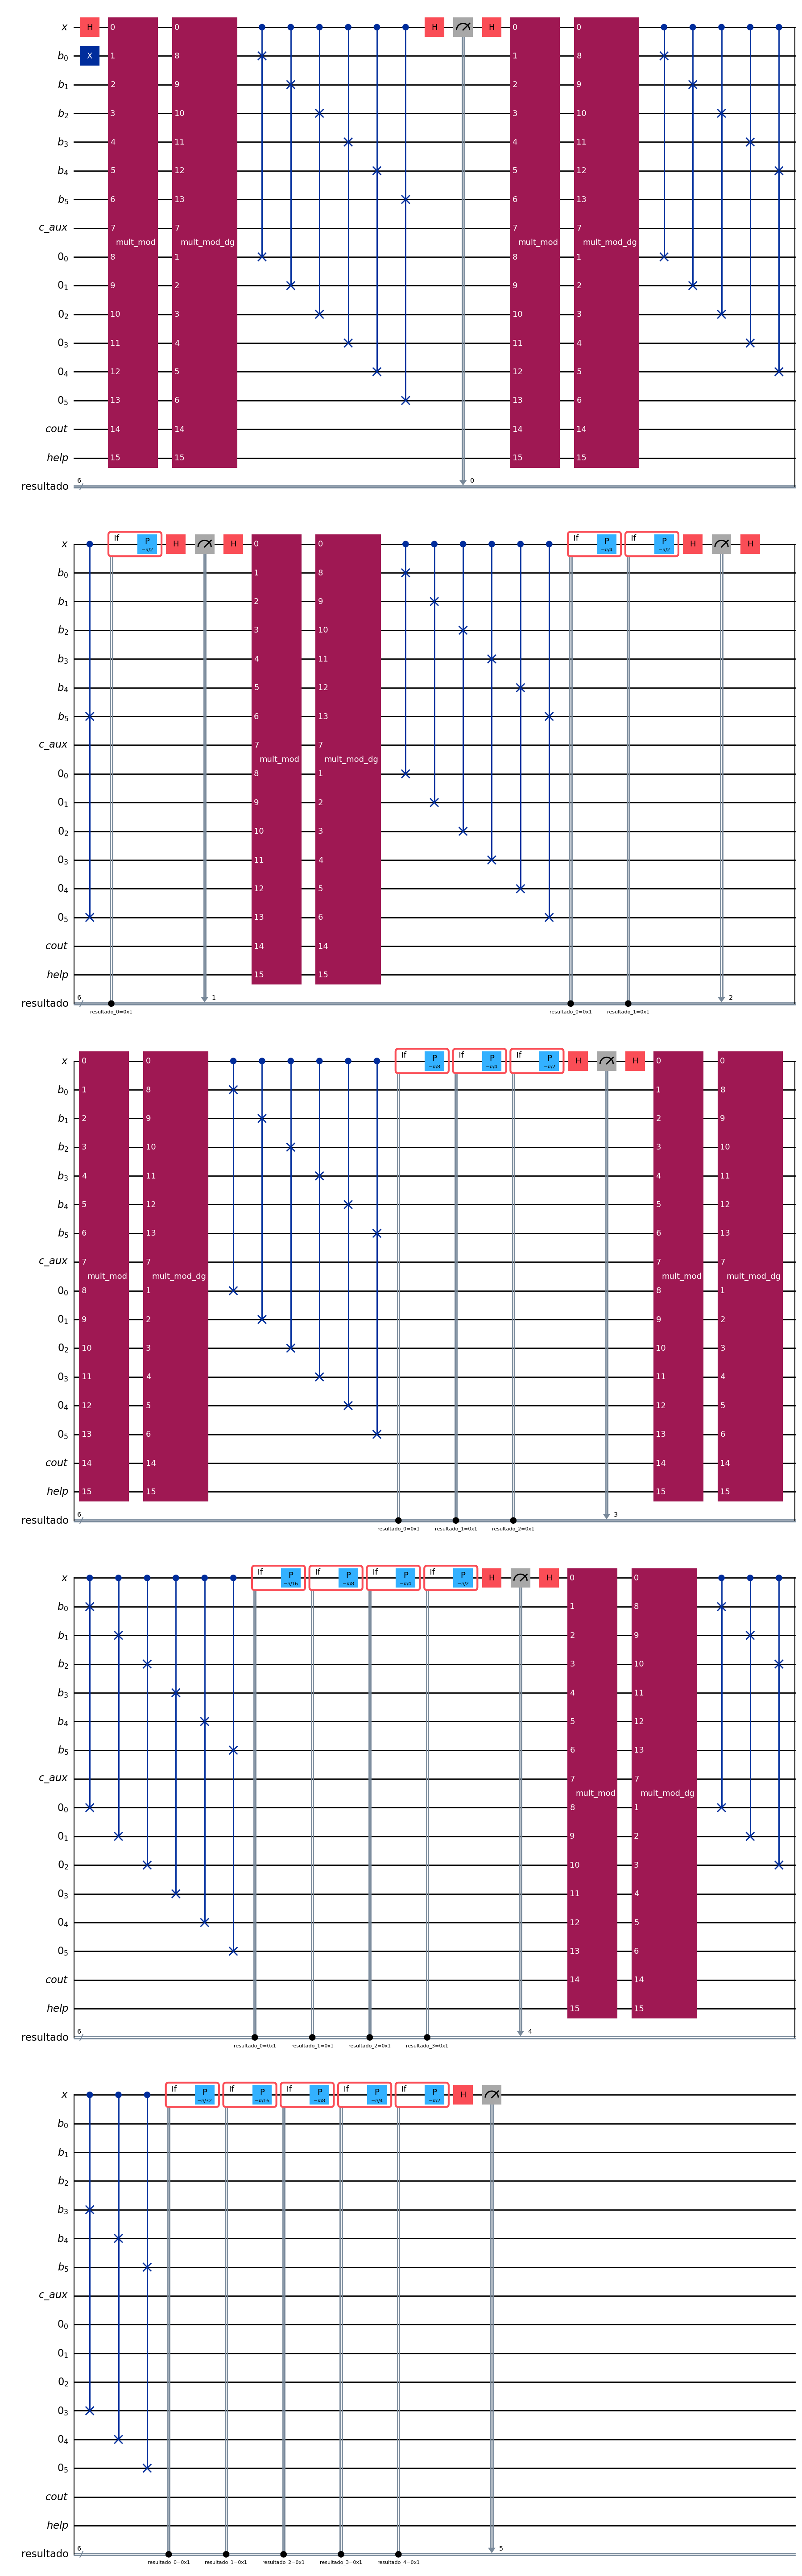

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from ctrl_mult_mod import ctrl_mult_mod
from math import log2, pi

def semi_classical_QFT_inv(qc,q_reg,c_reg):
      try:
          n = q_reg.size
      except:
          n = len(q_reg)
      for i in range(n-1,-1,-1):
          for j in range(n-1,i,-1):
              with qc.if_test((c_reg[n-1-j],1)) as else_:
                  qc.p((-pi/(2**(j-(i)))),q_reg[i])
              # with else_:
              #     pass
          qc.h(q_reg[i])
          qc.measure(q_reg[i],c_reg[n-1-i])

def semi_classical_qiskit_QFT_inv(qc,q_reg,c_reg):
      try:
          n = q_reg.size
      except:
          n = len(q_reg)
      for i in range(n):
          for j in range(i):
              with qc.if_test((c_reg[n-1-j],1)) as else_:
                  qc.p((-pi/(2**(i-j))), q_reg[i])
              # with else_:
              #     pass
          qc.h(q_reg[i])
          qc.measure(q_reg[i],c_reg[n-1-i])


def semi_classical_QFT_inv_1_bit(qc, q_reg, c_reg, n):
    """ Aplica a IQFT semi clássica em um qubit
    
    qc : QuantumCircuit
        Circuito quântico para aplicar a IQFT
    q_reg : QuantumRegister
        Registrador quântico para a qft ser aplicada (será aplicada no 1o bit)
    c_reg : ClassicalRegister
        Registrador clássico para a medição dos qubits
    n : int
        Número de bits na IQFT original

    """

    for i in range(n-1,-1,-1):
        for j in range(n-1,i,-1):
            with qc.if_test((c_reg[n-1-j],1)) as else_:
                qc.p((-pi/(2**(j-(i)))), q_reg[0])
            # with else_:
            #     pass
        qc.h(q_reg[0])
        qc.measure(q_reg[0],c_reg[n-1-i])


def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1

    
    circuit.h(n)
    for qubit in range(n):
        if qubit >= 0:
            circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    return circuit

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    #swap_registers(circuit, n)
    return circuit


def gcdExtended(a, b): 
    # Base Case 
    if a == 0 : 
        return b,0,1
             
    gcd,x1,y1 = gcdExtended(b%a, a) 
     
    # Update x and y using results of recursive 
    # call 
    x = y1 - (b//a) * x1 
    y = x1 
     
    return gcd,x,y 

def mod_inverse(x, p):
    gcd, inv, _ = gcdExtended(x, p)
    if gcd != 1:
        raise ValueError("O inverso não existe")
    return inv % p

N = 33  # N = p*q; p, q primos
n_bits = int(log2(N))+1

A = 2 # Base do expoente

b = 1 # Registrador inicial da multiplicação

x_bits = n_bits # q=2**x_bits, tamanho da amostra

reg_x = QuantumRegister(1, "x")
#number_x = QuantumCircuit(reg_x)

reg_b = QuantumRegister(n_bits, "b")
number_b = QuantumCircuit(reg_b)
number_b.initialize(b)

reg_c_aux = QuantumRegister(1, "c_aux")

reg_0 = QuantumRegister(n_bits, "0")

reg_cout = QuantumRegister(1, "cout")

reg_help = QuantumRegister(1, "help")

reg_result = ClassicalRegister(x_bits, "resultado")


#x_bits + 2*n_bits + 3
expmod = QuantumCircuit(reg_x, reg_b, reg_c_aux, reg_0, reg_cout, reg_help, name="expmod")

circuito = QuantumCircuit(reg_x, reg_b, reg_c_aux, reg_0, reg_cout, reg_help, reg_result)


#circuito.h(reg_x)
#circuito.append(number_b, reg_b)
circuito.x(reg_b[0])

for i in range(x_bits-1,-1,-1):
    circuito.h(reg_x[0])
    circuito.append(ctrl_mult_mod(n_bits, (A**(2**(i))) % N, N), reg_x[:1] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

    for j in range(N):
        if (A**(2**(i)) * j) % N == 1:
                a_inv = j
                break

    circuito.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[:1] + reg_0[:] + reg_c_aux[:] + reg_b[:] + reg_cout[:] + reg_help[:])

    for j in range(n_bits):
        circuito.cswap(reg_x[0], reg_b[j], reg_0[j])

    for j in range(x_bits-1,i,-1):
        with circuito.if_test((reg_result[x_bits-1-j],1)) as else_:
            circuito.p((-pi/(2**(j-(i)))), reg_x[0])
        # with else_:
        #     pass
    circuito.h(reg_x[0])
    circuito.measure(reg_x[0], reg_result[x_bits-1-i])

"""
for i in range(x_bits):

        circuito.append(ctrl_mult_mod(n_bits, (A**(2**(i))) % N, N), reg_x[:1] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

        for j in range(N):
            if (A**(2**(i)) * j) % N == 1:
                a_inv = j
                break

        circuito.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[:1] + reg_0[:] + reg_c_aux[:] + reg_b[:] + reg_cout[:] + reg_help[:])

        for j in range(n_bits):
            circuito.cswap(reg_x[0], reg_b[j], reg_0[j])
"""

"""
for i in range(x_bits):

        expmod.append(ctrl_mult_mod(n_bits, (A**(2**i)) % N, N), reg_x[i:i+1] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

        for j in range(N):
            if (A**(2**i) * j) % N == 1:
                a_inv = j
                break

        expmod.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[i:i+1] + reg_0[:] + reg_c_aux[:] + reg_b[:] + reg_cout[:] + reg_help[:])

        for j in range(n_bits):
            expmod.cswap(reg_x[i], reg_b[j], reg_0[j])
"""

#circuito.append(expmod, reg_x[:] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

#for i in range(n_bits):
#  circuito.cx(reg_b[i], reg_extra[i])

#circuito.append(expmod.inverse(), reg_x[:] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

#circuito.append(QFT(x_bits).inverse(), reg_x[:])
#QFT_correction(circuito, reg_x)

qftcirc = QuantumCircuit(n_bits)
qft(qftcirc, n_bits)

#circuito.append(qftcirc.inverse(), reg_x)

#semi_classical_QFT_inv_1_bit(circuito, reg_x, reg_result, x_bits)
#semi_classical_qiskit_QFT_inv(circuito, reg_x, reg_result)
#semi_classical_QFT_inv(circuito, reg_x, reg_result)

#circuito.measure(reg_x[:], reg_result)



#expmod.draw("mpl")
circuito.draw("mpl")


In [159]:
from qiskit_aer import AerSimulator
#from qiskit_addon_aqc_tensor.simulation.aer import QiskitAerSimulationSettings
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(circuito, backend=backend1)

"""
from qiskit.primitives import StatevectorSampler

statevectorsampler = StatevectorSampler()
pub = (qc1)
job = statevectorsampler.run([pub], shots=4096)
print(job.result()[0].data.resultado.get_int_counts())
"""


from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1024)
print("b=" + str(b), "A=" + str(A), "N=" + str(N))

counts = job.result()[0].data.resultado.get_int_counts()

print(counts)


b=1 A=2 N=33
{54: 27, 15: 10, 23: 25, 8: 5, 32: 87, 42: 7, 2: 22, 31: 13, 63: 16, 0: 103, 29: 54, 50: 6, 46: 23, 61: 48, 13: 19, 49: 28, 6: 1, 22: 34, 27: 44, 55: 24, 57: 11, 58: 32, 14: 41, 26: 32, 39: 25, 30: 13, 18: 5, 7: 36, 17: 20, 41: 9, 3: 5, 35: 5, 34: 19, 12: 4, 59: 30, 40: 5, 20: 2, 62: 7, 37: 5, 43: 8, 11: 13, 60: 2, 28: 5, 9: 7, 19: 2, 1: 3, 45: 14, 25: 8, 47: 17, 4: 6, 52: 7, 10: 6, 24: 3, 21: 3, 53: 6, 56: 5, 36: 3, 33: 1, 5: 2, 16: 1}


In [160]:

for i in counts:
    res = f"{i:9b}".strip()
    resB = "0b0" + res[:-x_bits]
    resA = "0b" + res[-x_bits:]
    print("|x>:", eval(resA),"|b*A^x mod N>:",eval(resB), "Esperado:", str(((b*A)**eval(resA)) % N))


#Resultado = job.result()[0].data.resultado.get_counts()
"""
Resultado_swap = {}

len_key = len(next(iter(Resultado)))
for key in Resultado:
  Resultado_swap[int(key[::-1], base=2)] = Resultado[key]


Resultado = job.result()[0].data.resultado.get_int_counts()


for i in range(1<<(x_bits)):
  if i not in Resultado_swap:
    Resultado_swap[i] = 1
"""

Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(x_bits)):
  if i not in Resultado:
    Resultado[i] = 1

|x>: 54 |b*A^x mod N>: 0 Esperado: 16
|x>: 15 |b*A^x mod N>: 0 Esperado: 32
|x>: 23 |b*A^x mod N>: 0 Esperado: 8
|x>: 8 |b*A^x mod N>: 0 Esperado: 25
|x>: 32 |b*A^x mod N>: 0 Esperado: 4
|x>: 42 |b*A^x mod N>: 0 Esperado: 4
|x>: 2 |b*A^x mod N>: 0 Esperado: 4
|x>: 31 |b*A^x mod N>: 0 Esperado: 2
|x>: 63 |b*A^x mod N>: 0 Esperado: 8
|x>: 0 |b*A^x mod N>: 0 Esperado: 1
|x>: 29 |b*A^x mod N>: 0 Esperado: 17
|x>: 50 |b*A^x mod N>: 0 Esperado: 1
|x>: 46 |b*A^x mod N>: 0 Esperado: 31
|x>: 61 |b*A^x mod N>: 0 Esperado: 2
|x>: 13 |b*A^x mod N>: 0 Esperado: 8
|x>: 49 |b*A^x mod N>: 0 Esperado: 17
|x>: 6 |b*A^x mod N>: 0 Esperado: 31
|x>: 22 |b*A^x mod N>: 0 Esperado: 4
|x>: 27 |b*A^x mod N>: 0 Esperado: 29
|x>: 55 |b*A^x mod N>: 0 Esperado: 32
|x>: 57 |b*A^x mod N>: 0 Esperado: 29
|x>: 58 |b*A^x mod N>: 0 Esperado: 25
|x>: 14 |b*A^x mod N>: 0 Esperado: 16
|x>: 26 |b*A^x mod N>: 0 Esperado: 31
|x>: 39 |b*A^x mod N>: 0 Esperado: 17
|x>: 30 |b*A^x mod N>: 0 Esperado: 1
|x>: 18 |b*A^x mod N>: 0 Esp

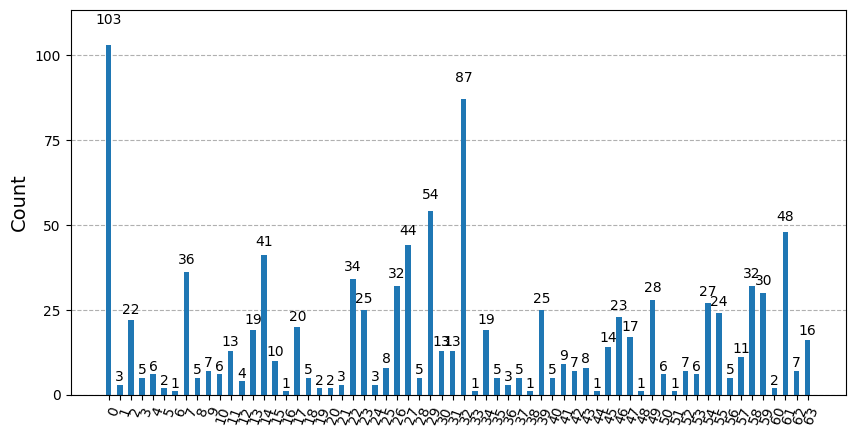

: 

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado, figsize=(10,5))